# Removed Features

* **categorical columns**: 'hard_coral_class', 'country_name',
'ocean_name', 'ecoregion', 'province', 'realm'


* **numerical features**: 'temperature_kelvin_standard_deviation', 'ssta_frequency_standard_deviation', 'ssta_frequencymean', '50reef_cyclirt1', 'tsa_mean', 'tsa_frequencymean', 'tsa_standard_deviation'


*   1792 **image features**: removed as columns only contains less than 6 unique values (not enough variance)

## Additional work done:

*   SMOTE was the best method so far to manage class imbalance.
*   Removing all geographical features due to high correlation and keeping city_town_name due to high variance. Keeping this feature improved performance signficantly.
*   Did hyperparameter tuning using grid search, obtained optimized parameters.
*   Interaction terms worsened performance due to high correlation.
* Removing additional image features caused performance to decrease.
* MinMax scalar performed better than standard scalar





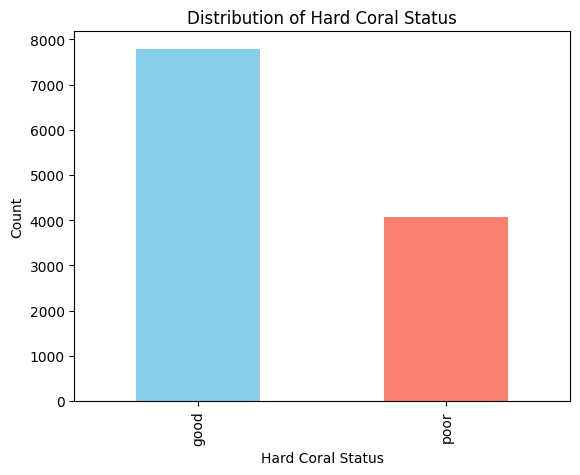



New dataset is called *full_data_cleaned.csv*

In [ ]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve,  make_scorer, f1_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate



In [ ]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pd.set_option('display.max_columns', None)

# Now, print the data_columns list
data_columns = full_data_cleaned.columns.tolist()
print(full_data_cleaned)

             date  latitude_degrees  longitude_degrees  \
0      2014-08-28            6.5139           117.9243   
1      2014-08-29           25.6626           -79.3077   
2      2014-08-29           18.5999           -74.4281   
3      2014-08-29            6.5210           117.9157   
4      2014-08-30           18.6559           -74.3077   
...           ...               ...                ...   
11861  2018-11-29           -8.1089           115.3169   
11862  2018-11-29           -8.0942           115.2733   
11863  2018-11-29           -4.5106           129.9464   
11864  2018-11-30           -8.1290           115.3656   
11865  2018-11-30           -4.5175           129.9461   

                                                     url  depth_m ocean_name  \
0      https://oceancolor.gsfc.nasa.gov/showimages/MO...      6.8    Pacific   
1      https://oceancolor.gsfc.nasa.gov/showimages/MO...      5.0   Atlantic   
2      https://oceancolor.gsfc.nasa.gov/showimages/MO...      3

# RANDOM FOREST MODEL
## Using a small subset of features for predictive binary classification

In [ ]:
# Load the CSV file
#full_data_cleaned = pd.read_csv('full_data_cleaned.csv')

filename = '/content/drive/My Drive/Capstone/Notebooks/Final_Model_notebook/full_data_cleaned.csv'
full_data_cleaned = pd.read_csv(filename)

In [ ]:
# Filter out columns that start with 'feature_' and have fewer than 6 unique values
columns_to_remove = [
    col for col in full_data_cleaned.columns
    if col.startswith('feature_') and full_data_cleaned[col].nunique() < 6
]

# Drop the columns identified
full_data_cleaned = full_data_cleaned.drop(columns=columns_to_remove)

# Filter out columns that start with 'city_town_name_'
columns_to_remove = [
    col for col in full_data_cleaned.columns
    if col.startswith('city_town_name')
]

# Drop the columns identified
full_data_cleaned = full_data_cleaned.drop(columns=columns_to_remove)

# Filter out columns that start with 'feature'
columns_to_remove = [
    col for col in full_data_cleaned.columns
    if col.startswith('feature')
]

# Drop the columns identified
full_data_cleaned = full_data_cleaned.drop(columns=columns_to_remove)

# Drop additional features
columns_to_remove = ['date_day','date_month','date_year','percent_bleaching','bleaching_level','50reef_score','ssta_frequency','ssta_frequencymax','r','g','b',
                     'ssta', 'ssta_frequency', 'ssta_frequencymax',
                     'tsa_minimum', 'tsa_frequency','longitude_degrees','latitude_degrees','temperature_mean', 'temperature_maximum',
                     'iucn_category', 'mpa', 'overfishing',
                     'hdi','ssta_dhw','tsa_dhwmax',
                     'exposure','marine_pollution','coastal_dev',
                     '50reef_connpe','50reef_cyclavg'] #, 'ssta_minimum', 'ssta_maximum']
full_data_cleaned = full_data_cleaned.drop(columns=columns_to_remove)

from sklearn.preprocessing import MinMaxScaler

# Create a new column 'Hard Coral Status' based on the condition
full_data_cleaned['hard_coral_status'] = np.where(
    full_data_cleaned['hard_coral'] < 20, 'poor', 'good'
)

# Drop columns not needed for modeling, concluded from EDA
full_data_cleaned = full_data_cleaned.drop(['url', 'image_features',
                                            'hard_coral_class', 'country_name',
                                            'ocean_name', 'ecoregion', 'province',
                                            'realm'], axis=1)


df_cleaned = full_data_cleaned

df_cleaned = df_cleaned.drop(['date'], axis=1)
model_data = df_cleaned.drop(['hard_coral'], axis=1)

# Create and fit scaler
scaler = StandardScaler()

# Select numerical columns to scale
features = ['depth_m', 'distance_to_shore', 'turbidity','cyclone_frequency','temperature_kelvin','windspeed','ssta_minimum','ssta_maximum']

# Prepare the features (X) and target (y), dropping the date column after sorting
X = model_data.drop(['hard_coral_status'], axis=1)
y = model_data['hard_coral_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
#X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_train_resampled, y_train_resampled = X_train, y_train

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, roc_auc_score, f1_score

# Define the optimized Random Forest model with class weights
optimized_rf_model = RandomForestClassifier(
    bootstrap=False,
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=500,
    random_state=42,
    #n_jobs=-1,
    class_weight='balanced'
)

optimized_rf_model.fit(X_train_resampled, y_train_resampled)
test_predictions = optimized_rf_model.predict(X_test)
test_proba = optimized_rf_model.predict_proba(X_test)[:, 1]

from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
print("Test Accuracy:", accuracy_score(y_test, test_predictions))
print("Test ROC AUC:", roc_auc_score(y_test, test_proba))
print("Test F1 Weighted:", f1_score(y_test, test_predictions, average='weighted'))


Test Accuracy: 0.7681159420289855
Test ROC AUC: 0.8086073651741071
Test F1 Weighted: 0.7660517655907912


In [ ]:
model_data.columns.tolist()

['depth_m',
 'distance_to_shore',
 'turbidity',
 'cyclone_frequency',
 'climsst',
 'temperature_kelvin',
 'windspeed',
 'ssta_minimum',
 'ssta_maximum',
 'nutrient_indicator_algae',
 'hard_coral_status']

In [ ]:
# Saved the trained model
import pickle

model_filename  = '/content/drive/My Drive/Capstone/small_rf_model.pkl'
with open(model_filename, 'wb') as file:
  pickle.dump(optimized_rf_model, file)

# UNIT TEST MODEL RECALL AND PREDICTION

In [ ]:
import pickle

# Load the trained model
model_filename = '/content/drive/My Drive/Capstone/small_rf_model.pkl'
with open(model_filename, 'rb') as file:
  model = pickle.load(file)

In [ ]:
# UNIT TEST

# Run a predictive test
# Define test case
"""
data = {
    'depth_m': [5.0],
    'distance_to_shore': [3216.61],
    'turbidity': [0.0493],
    'cyclone_frequency': [53.66],
    'climsst': [302.35],
    'temperature_kelvin': [304.39],
    'windspeed': [4.0],
    'ssta_minimum': [-3.82],
    'ssta_maximum': [3.19],
    'nutrient_indicator_algae': [5.62]
}
"""

data = {
    'depth_m': [5.0],
    'distance_to_shore': [32560],
    'turbidity': [0.0493],
    'cyclone_frequency': [53.66],
    'climsst': [302.35],
    'temperature_kelvin': [304.39],
    'windspeed': [4.0],
    'ssta_minimum': [-3.82],
    'ssta_maximum': [3.19],
    'nutrient_indicator_algae': [0.8]
}

X_test = pd.DataFrame(data)

data_predict = {
    'hard_coral_status': ['good']
}
y_test = pd.DataFrame(data_predict)

# Run prediction
test_predictions = model.predict(X_test)
test_proba = model.predict_proba(X_test)[:, 1]

print("Test Accuracy:", accuracy_score(y_test, test_predictions))
#print("Test ROC AUC:", roc_auc_score(y_test, test_proba))
#print("Test F1 Weighted:", f1_score(y_test, test_predictions, average='weighted'))

Test Accuracy: 1.0


In [ ]:
test_predictions

# RF MULTICLASS

In [ ]:
# Load the CSV file
#full_data_cleaned = pd.read_csv('full_data_cleaned.csv')

filename = '/content/drive/My Drive/Capstone/Notebooks/Final_Model_notebook/full_data_cleaned.csv'
full_data_cleaned = pd.read_csv(filename)

In [ ]:
from sklearn.model_selection import train_test_split

# Filter out columns that start with 'feature_' and have fewer than 6 unique values
columns_to_remove = [
    col for col in full_data_cleaned.columns
    if col.startswith('feature_') and full_data_cleaned[col].nunique() < 6
]

# Drop the columns identified
full_data_cleaned = full_data_cleaned.drop(columns=columns_to_remove)

# Filter out columns that start with 'city_town_name_'
columns_to_remove = [
    col for col in full_data_cleaned.columns
    if col.startswith('city_town_name')
]

# Drop the columns identified
full_data_cleaned = full_data_cleaned.drop(columns=columns_to_remove)

# Filter out columns that start with 'feature'
columns_to_remove = [
    col for col in full_data_cleaned.columns
    if col.startswith('feature')
]

# Drop the columns identified
full_data_cleaned = full_data_cleaned.drop(columns=columns_to_remove)

# Drop additional features
columns_to_remove = ['date_day','date_month','date_year','percent_bleaching','bleaching_level','50reef_score','r','g','b',
                     'tsa_minimum', 'tsa_frequency','longitude_degrees','latitude_degrees',
                     'iucn_category', 'mpa', 'overfishing',
                     'hdi','ssta_dhw','tsa_dhwmax',
                     'exposure','marine_pollution','coastal_dev']
                     #'temperature_mean', 'temperature_maximum','ssta','ssta_frequency','ssta_frequencymax','50reef_connpe','50reef_cyclavg'] #, 'ssta_minimum', 'ssta_maximum']
full_data_cleaned = full_data_cleaned.drop(columns=columns_to_remove)

from sklearn.preprocessing import MinMaxScaler

# Create a new column 'Hard Coral Status' based on the condition
full_data_cleaned['hard_coral_status'] = np.where(full_data_cleaned['hard_coral'] < 20, 'poor',
           np.where(full_data_cleaned['hard_coral'] < 40, 'fair', 'good')
)

# Drop columns not needed for modeling, concluded from EDA
full_data_cleaned = full_data_cleaned.drop(['url', 'image_features',
                                            'hard_coral_class', 'country_name',
                                            'ocean_name', 'ecoregion', 'province',
                                            'realm'], axis=1)


# Categorical columns for one-hot encoding
#encode_categorical_columns = ['exposure',
#                              'marine_pollution',
#                              'coastal_dev']
                              #'mpa'] #'bleaching_level', 'city_town_name', 'iucn_category', 'mpa', 'overfishing',]

# Convert categorical variables into numerical form using one-hot encoding
#data_encoded = pd.get_dummies(full_data_cleaned, columns=encode_categorical_columns, drop_first=False)

#df_cleaned = data_encoded.loc[:, data_encoded.nunique() > 1]
df_cleaned = full_data_cleaned

df_cleaned = df_cleaned.drop(['date'], axis=1)
model_data = df_cleaned.drop(['hard_coral'], axis=1)

# Initialize MinMaxScaler
#scaler = MinMaxScaler()

# Select numerical columns to scale
#numerical_columns = model_data.select_dtypes(include=['float64', 'int64']).columns

# Apply scaling to the numerical columns (including interaction terms)
#model_data[numerical_columns] = scaler.fit_transform(model_data[numerical_columns])

# Prepare the features (X) and target (y), dropping the date column after sorting
X = model_data.drop(['hard_coral_status'], axis=1)
y = model_data['hard_coral_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data
#smote = SMOTE(random_state=42)
#X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_train_resampled = X_train
y_train_resampled = y_train

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, roc_auc_score, f1_score

# Define the optimized Random Forest model with class weights
optimized_rf_model = RandomForestClassifier(
    bootstrap=False,
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=500,
    random_state=42,
    #n_jobs=-1,
    class_weight='balanced'
)

optimized_rf_model.fit(X_train_resampled, y_train_resampled)
test_predictions = optimized_rf_model.predict(X_test)
test_proba = optimized_rf_model.predict_proba(X_test)[:, 1]

from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
print("Test Accuracy:", accuracy_score(y_test, test_predictions))
#print("Test ROC AUC:", roc_auc_score(y_test, test_proba))
print("Test F1 Weighted:", f1_score(y_test, test_predictions, average='weighted'))

Test Accuracy: 0.6145745577085089
Test F1 Weighted: 0.6146461420878139


In [ ]:
# Saved the trained model
import pickle

model_filename  = '/content/drive/My Drive/Capstone/small_rf_multimodel.pkl'
with open(model_filename, 'wb') as file:
  pickle.dump(optimized_rf_model, file)